In [60]:

import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# from lightgbm import LGBMClassifier
#
# from imblearn.over_sampling import RandomOverSampler
# from collections import Counter
#
# from boruta import BorutaPy

import time


In [61]:
%matplotlib inline

warnings.simplefilter("ignore")
pd.set_option("display.max_columns", 999)

In [62]:
TRAIN_PATH = "data/data_train.csv"
TEST_PATH = "data/data_test.csv"
FEATURES_PATH = "data/features.csv"

data_train = pd.read_csv(TRAIN_PATH)
data_test = pd.read_csv(TEST_PATH)

# Обзор данных

In [63]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


Размер более 30 Мб, для облегчения применим функцию

In [64]:
# уменьшение потребляемой памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of the dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [65]:
data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Memory usage of the dataframe is 31.73 MB
Memory usage after optimization is: 15.86 MB
Decreased by 50.0%
Memory usage of the dataframe is 2.17 MB
Memory usage after optimization is: 1.09 MB
Decreased by 50.0%


In [66]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int32  
 1   id          831653 non-null  int32  
 2   vas_id      831653 non-null  float32
 3   buy_time    831653 non-null  int32  
 4   target      831653 non-null  float32
dtypes: float32(2), int32(3)
memory usage: 15.9 MB


In [67]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int32  
 1   id          71231 non-null  int32  
 2   vas_id      71231 non-null  float32
 3   buy_time    71231 non-null  int32  
dtypes: float32(1), int32(3)
memory usage: 1.1 MB


In [68]:
data_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


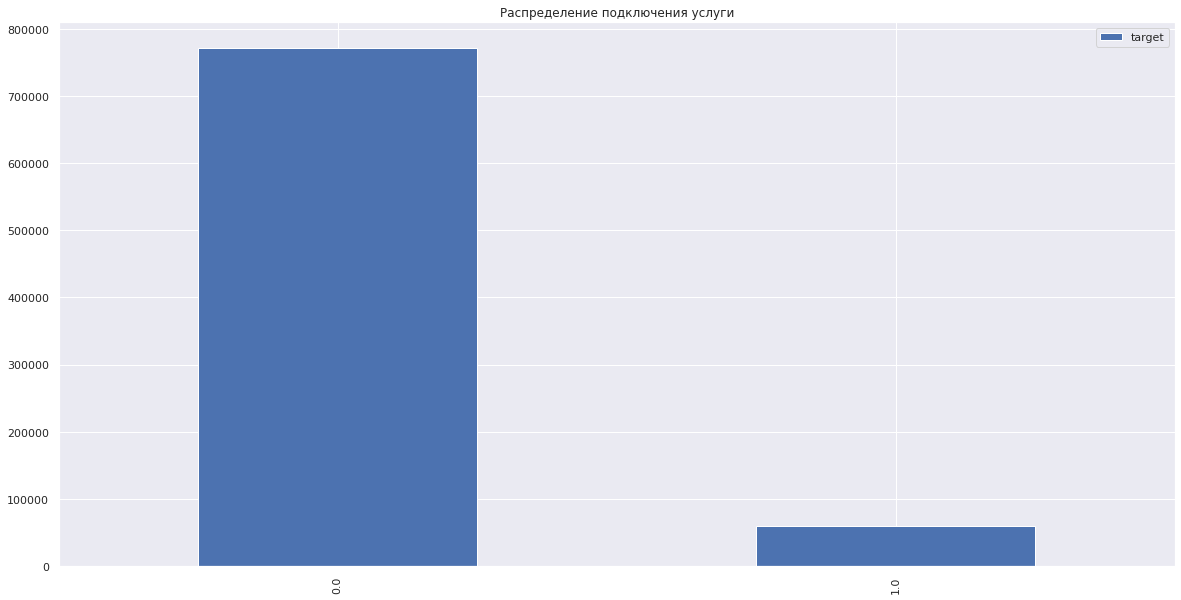

In [69]:
plt.figure(figsize=(20, 10))
data_train['target'].value_counts().plot(kind='bar', label='target')
plt.legend()
plt.title('Распределение подключения услуги');

Видно большой дисбаланс классов.

In [70]:
data_train['buy_time'] = data_train.apply(lambda x: pd.Timestamp.fromtimestamp(x['buy_time']), axis=1)
data_test['buy_time'] = data_test.apply(lambda x: pd.Timestamp.fromtimestamp(x['buy_time']), axis=1)

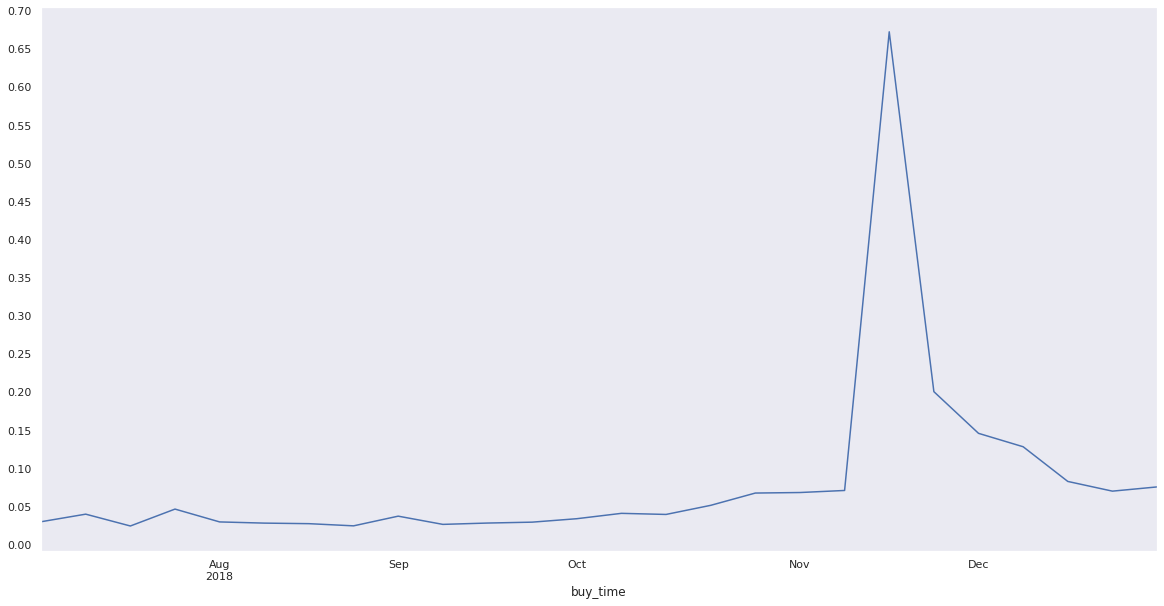

In [71]:
plt.figure(figsize=(20, 10))
data_train.groupby(['buy_time'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(data_train['buy_time'].unique())
plt.yticks(np.arange(0, 0.71, 0.05))
plt.grid()
plt.savefig("buy_time-target.png")

plt.show()

Видно аномально большое количество подключений 19 ноября и плавный спад в последующие даты. Вероятно, была проведена некая акция.
В тестовом периоде предположительно, ничего подобного не было. Возможно, данный "пик" искажает реальную совокупность. Не имея дополнительной информации, не представляется возможным отличить абонентов, подключившихся по акции от тех, кто сделал это независимо. Вероятно, стоит исключить 19-е ноября из обучающей выборки.

In [72]:
mask = data_train['buy_time'] == '2018-11-19'

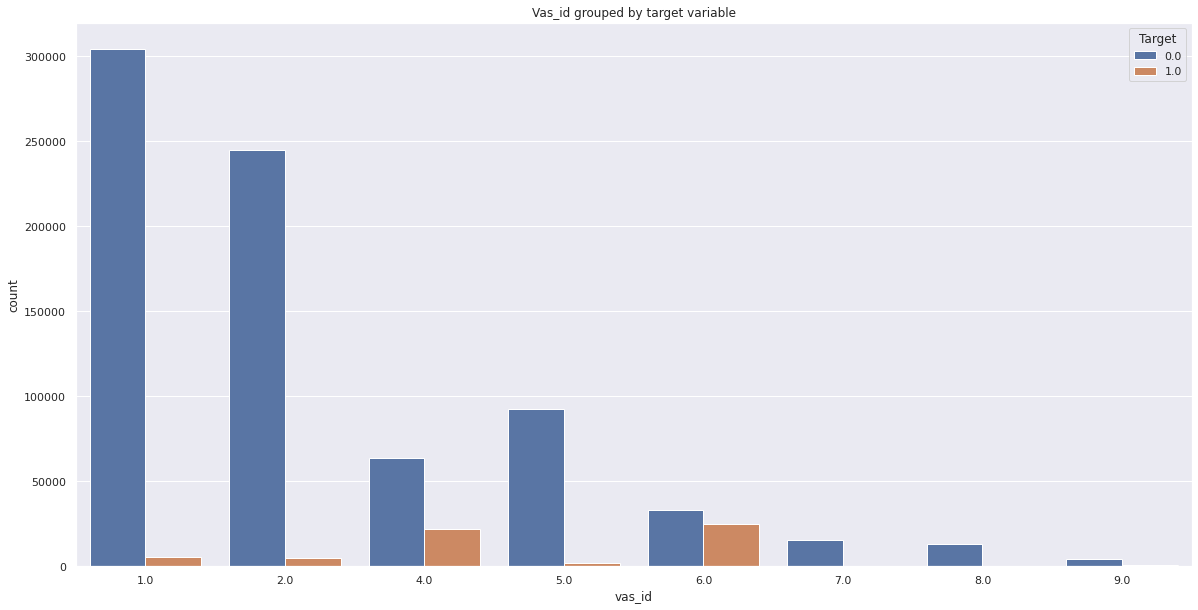

In [73]:
plt.figure(figsize=(20, 10))

sns.countplot(x="vas_id", hue=data_train['target'], data=data_train)
plt.title('Vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.savefig("vas_id-target2.png")

plt.show()

Довольно сложно трактовать график. Так, услуги 1 и 2 предлагались максимальному количеству абонентов, но особым откликом не отличились. В то время как у 4 и, особенно, 6 - имеют значительно больше процент подключившихся. Понятно, что все услуги предлагают разную выгоду абонентам и издержки кампании, и для трактовки, вероятно, не хватает бизнес-информации.

In [55]:
data_train.duplicated(subset=['id']).value_counts()

False    806613
True      25040
dtype: int64

Id пользователей иногда повторяется. Вероятно, абоненты имеют несколько симкарт.

Датасет с признаками содержит более 4-х млн строк. Трейн и тест выборки значительно меньше, многие строки попросту не пригодятся при решении задачи, т.к. не содержат информации об интересующей услуге. Поэтому, предварительно возьмем  только ту информацию, которая окажется полезной.

In [48]:
def process_featues(data_features, train, test):
    ids = np.unique(train['id'].append(test['id']))
    # Возьмем id только тех пользователей, что встречаются в трейн и тест выборках.
    data_features = data_features[data_features['id'].isin(ids)]
    # Дропнем Unnamed
    if 'Unnamed: 0' in data_features:
        data_features = data_features.drop(columns='Unnamed: 0')

    data_features = data_features.compute()
    # удалим признаки с единственным значением
    df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    data_features = data_features.drop(columns = const)
    # функция сжатия данных
    data_features = reduce_mem_usage(data_features)
    return data_features

In [49]:
import dask.dataframe as dd

data_features = dd.read_csv(FEATURES_PATH, sep ='\t')

data_features =process_featues(data_features, data_train, data_test)

Memory usage of the dataframe is 1728.06 MB
Memory usage after optimization is: 867.47 MB
Decreased by 49.8%


In [51]:
data_features.head()

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820038,1599.480835,286.879211,1585.013184,281.461761,1563.908203,-16.08618,654.013916,-6.78366,-30.006538,-2.736328,-4.007526,-2.558594,259.25000,320.00000,-0.000725,-0.016434,-0.107056,-5.417969,-3.177734,-13.937500,-10.742188,-0.094238,-0.001733,-0.009331,-2.082031,0.200195,-0.009094,-0.351807,-0.214355,-0.211548,-0.001884,-0.000023,-0.00003,-2.660156,-0.065613,-0.700684,-192.026962,-2697.843750,-942.169128,-1755.674561,-89.504288,-119.724358,276.500000,179.750000,96.875000,-7.894531,-6.994502,-10.717958,-27.612844,-11.132812,-15.085938,-12.171875,-5.332031,-3.958984,-7.746094,-1.670898,-0.001656,63.312500,20.125000,0.434814,-0.148193,0.098328,0.392334,0.074341,-0.028458,-0.044464,-0.301025,-0.554688,-0.036835,3.869141,-2.783203,-2.607422,-5.390625,-4.023438,-2.824219,-10.703125,-1.2015,-0.998268,-0.203247,-0.248779,-0.2229,-0.134033,-0.030533,-0.125854,-0.096985,-0.679688,-0.626953,-0.691895,-0.506836,-0.185303,-0.598633,-0.000115,-0.250244,-0.348877,-0.828613,-42.275913,-3.949219,-0.25293,-0.318115,-2.291016,-3.447266,-0.040039,-9.406250,-0.212158,61.375000,-1.019531,-2.472656,5.378906,-943.365051,-1757.811279,0.402100,0.426025,-2701.176270,-2298.725098,-0.343506,-0.089722,-0.278809,-0.433105,-0.024048,-89.211945,-119.674408,-208.886353,-0.058075,-0.060455,0.334961,4.382812,42.312500,1.426758,-0.468506,-0.217285,-190.625,-1.143555,-2.722656,-0.826172,-1.935547,-1.276367,-0.020142,-0.042633,94.312500,540.5000,34.031250,-34.875000,-3.861328,0.182861,-0.007023,0.356689,-8.414062,-0.212646,-0.019562,-0.000044,-0.000379,-2.548828,-0.26123,0.463623,-0.061493,-0.1521,-0.002596,-3.677734,-0.014542,0.180542,-21.187500,-44.375000,-25.312500,-52.00000,38.031250,179.750000,-7.613281,6.445312,-0.028854,-0.063232,-0.019196,-0.033783,-0.003149,-0.005184,-0.001431,-0.00189,-1.257812,-2.792969,-1.932617,-5.007812,39.031250,96.812500,-2.355469,2.496094,-0.034576,-0.163208,3886.0000,-0.466797,4.070312,-0.623535,-0.228149,0.748047,-0.000567,-0.433838,-0.000708,-0.029205,-0.104675,-0.001357,-0.960938,0.665527,-0.008995,-11953.712891,-45175.257812,-0.623047,-30.716053,-61790.15625,0.756836,-36221.167969,-9239.707031,-2.107422,-0.000083,-0.623047,-0.00004,-0.620605,-0.01226,-0.107849,-572669504.0,-58.53125,1.092670e+09,-120441800.0,-3.917969,-1.464844,-33.30238,-230.128983,-32.781250,-0.364746,-0.133789,-0.209473,-28.359375,-109.884567,-876.691040,-5.367188,-247.125,-108.4375,-512.437317,-106.617981,-17.296875,-977.37384,-613.770813,-25.996269,-35.625,-295.747711,-17.832888,-0.694336,-4.175933,-0.456055,0.0
16,2050810,1540760400,-86.209969,91.820885,-84.480789,110.333199,-89.898247,89.228210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736328,-4.007526,-2.558594,-66.18750,-66.93750,-0.000725,-0.016434,-0.107056,-5.417969,-3.177734,1.729492,-10.742188,-0.094238,-0.001733,-0.009331,-2.082031,0.200195,-0.009094,-0.351807,-0.214355,-0.211548,-0.001884,-0.000023,-0.00003,-2.660156,-0.065613,-0.700684,-192.026962,-2655.593750,-991.295166,-1664.298584,-89.504288,-119.724358,-0.028687,2.730469,-2.759766,-7.894531,-7.909355,-10.717958,-28.571102,-10

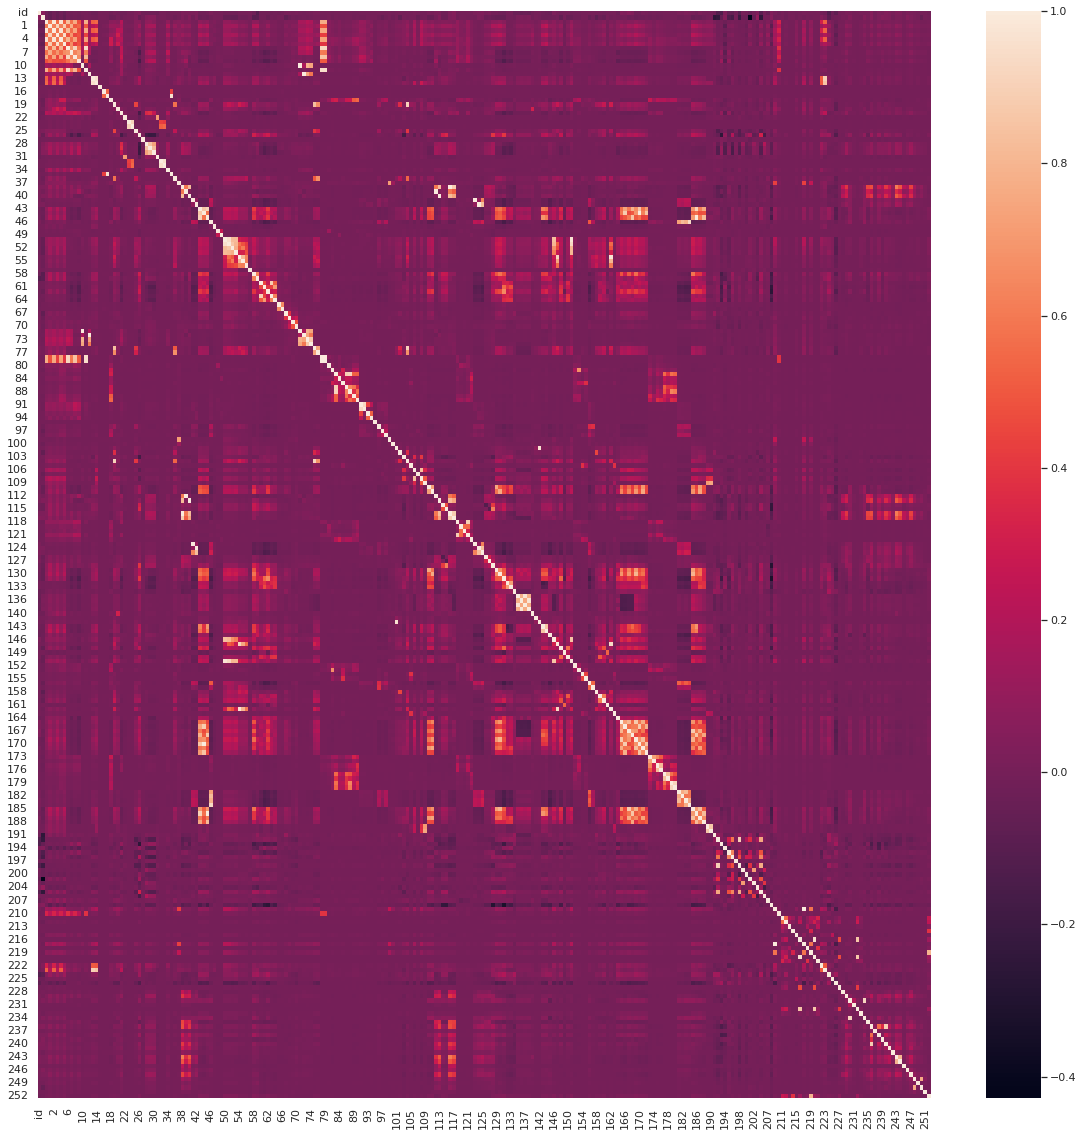

In [54]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(data_features.corr());

По тепловой карте видно, что есть группы признаков с высокой корреляцией. Зачастую коррелирующие признаки идут подряд, что может говорить о том что они частично повторяются, но поскольку данные обезличены, невозможно отобрать наиболее характерные признаки из данных групп. Вероятно, модель будет переобучаться. Необходимо использовать регуляризацию.

TypeError: an integer is required (got type Timestamp)

Объединим

In [79]:
# data_features = data_features.compute()
type(data_features)

pandas.core.frame.DataFrame

In [95]:
train_merge = data_train.merge(data_features, on='id', how = 'left')
test_merge = data_test.merge(data_features, on='id', how = 'left')

In [93]:
train_merge.head()

,Unnamed: 0,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,540968,8.0,2018-09-17,0.0,1541970000,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736328,56.284081,-2.558594,-66.187500,-77.500000,-0.000725,-0.016434,-0.107056,-5.417969,-3.177734,-13.937500,54.500000,-0.094238,-0.001733,-0.009331,-2.082031,0.200195,-0.009094,2.648438,0.785645,0.788574,-0.001884,-0.000023,-0.00003,62.593750,-0.065613,-0.700684,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.511719,33.25000,-36.750000,-7.894531,-7.997875,-10.697456,-28.551693,-17.125,-16.09375,-26.171875,-5.332031,1.041016,-3.746094,-1.670898,-0.001656,9.320312,15.117188,0.174805,-0.108154,0.028351,-0.017578,-0.165649,-0.028458,-0.044464,-0.301025,-0.554688,-0.036835,-0.130005,-2.783203,-2.607422,-5.390625,-4.023438,-2.824219,-10.703125,-1.2015,-0.998268,-0.203247,-0.248779,-0.2229,-0.134033,-0.030533,-0.125854,-0.096985,-0.679688,-0.626953,-0.691895,-0.506836,-0.185303,-0.598633,-0.000115,-0.250244,-0.348877,-0.828613,-42.275913,-3.949219,-0.25293,-0.318115,-2.291016,-3.447266,-0.040039,-9.406250,-0.212158,-11.953125,-1.019531,-1.473633,0.379150,-1006.426575,1242.881104,0.032013,0.196167,236.454514,848.953552,-0.343506,-0.089722,-0.278809,-0.433105,-0.024048,-89.211945,-119.674408,-208.886353,0.031921,-0.030457,0.104858,1.381836,5.316406,1.426758,-0.468506,-0.017288,-190.625,5.855469,7.277344,2.173828,5.062500,-1.276367,-0.020142,-0.042633,-11.476562,-59.3750,34.031250,-17.890625,0.138550,-0.317139,-0.007023,-0.143311,-14.414062,-0.212646,-0.019562,-0.000044,-0.000379,-2.548828,-0.26123,-0.536133,-0.061493,-0.152100,-0.002596,1.322266,-0.014542,-0.009506,-8.179688,35.750000,-14.320312,-40.8125,-5.960938,33.18750,-12.617188,-26.671875,-0.028854,-0.063232,-0.019196,-0.033783,-0.003149,-0.005184,-0.001431,-0.00189,-1.257812,-2.792969,-1.932617,-5.007812,-15.976562,-36.81250,-9.351562,-25.328125,-0.034576,-0.163208,-109.0625,0.533203,-1.928711,-0.623535,-0.228149,-0.251953,-0.000567,0.566406,-0.000708,-0.029205,-0.104675,-0.001357,0.039215,0.665527,-0.008995,-11953.712891,-45175.257812,-0.623047,-30.716053,-61790.156250,-0.243164,-42051.167969,-9239.707031,-2.107422,-0.000083,-0.623047,-0.00004,-0.620605,-0.01226,-0.107849,969818880.0,-49.21875,-4.405604e+08,-120441800.0,-8.632812,-1.464844,-33.30238,810.871033,270.250000,-0.364746,-0.133789,-0.209473,269.750000,-109.884567,364.308990,41.625000,939.000,-108.437500,-504.437317,-53.617977,-12.296875,-845.37384,-613.770813,-20.996269,-37.625,-28.747725,4.167111,7.304688,-12.175933,21.546875,0.0
1,1,1454121,4.0,2018-07-16,0.0,1531083600,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736328,-4.007526,-2.558594,578.000000,566.500000,-0.000725,-0.016434,-0.107056,-5.417969,-3.177734,-13.937500,-10.742188,-0.094238,-0.001733,-0.009331,-2.082031,0.200195,-0.009094,-0.351807,-0.214355,-0.211548,-0.001884,-0.000023,-0.00003,-2.660156,-0.065613,-0.700684,-192.026962,-2764.330078,-1102.746338,-1661.583740,-89.504288,-119.724358,-119.68

In [98]:
train_merge.to_csv('data/train_merge.csv', index=False)

In [99]:
test_merge.to_csv('data/test_merge.csv', index=False)